### Question 1: Warming up with a multivariate normal distribution

Your astronomer friend working on star clusters has come up with a posterior for the probabiliy of finding a star within a cluster in position $(x,y,z)$. This posterior distribution happens to be a 3 dimensional multivariate normal with mean vector (1, 2, 3), variances each equal to 4, and an intraclass correlation
coefficient of 1.2; that is,

$$ 
p(x,y,z) \sim  N \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
    3  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2 & 1.2 \\ 
    1.2 & 4 & 1.2 \\ 
    1.2 & 1.2 & 4 \\  
  \end{array} 
  \right] \right)
$$ 

He comes to you because he wants to sample from this distribution, but he suspects that there is a bug in the multivariate normal function from numpy. You quickly realize that you can help him by using a Gibbs sampler. 

In the following we write $X = [x,y,z]$ and $X_k$ as the vector containing $k$ compontens of $X$, and $X_{-k}$ as the vector containing all the components except for $k$. 

In order to find any conditional distribution $p(X_k|X_{-k})$ of a multivariate normal dsitribution with dimension k, you can partition the covariance matrix as follows:

$$ \Sigma = \left[ \begin{array}{cc} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22}  \end{array} \right] $$

where $\Sigma_{11}$ is the submatrix of the covariance matrix obtained by deleting the rows and columnns where the variances of the conditioning variables are located, $\Sigma_{22}$ is the submatrix obtained by deleting the rows and columnns where the variances of the conditioned variables are located, and $\Sigma_{12} = \Sigma_{21}^T$ are the remaining matrices.

For our 3 dimensional problem we get:

$$
\Sigma = 
\left[
  \begin{array}{ccc}
    \sigma_x^2 & \sigma_x \sigma_y & \sigma_x \sigma_z \\ 
    \sigma_y \sigma_x & \sigma_y^2 & \sigma_y \sigma_z \\ 
    \sigma_z \sigma_x & \sigma_z \sigma_y & \sigma_z^2 \\  
  \end{array} 
  \right]
$$

so if we are interested in $p(x|y,z)$ we have $\Sigma_{11} = \left[\sigma_x\right], \Sigma_{12} = \Sigma_{21}^T = \left[ \sigma_x \sigma_y \quad \sigma_x \sigma_z \right]$, and $\Sigma_{22} = \left[   \begin{array}{cc}
    \sigma_y^2 & \sigma_y \sigma_z \\ 
    \sigma_z \sigma_y & \sigma_z^2 \\  
  \end{array} \right]$ 

We can do this for all three conditional distributions and because our example is so nicely symmetric we get the same sub-matrices for each of the conditionals:

$$ \Sigma_{11} = \left[ 4 \right] $$

$$ \Sigma_{12} = \Sigma_{21}^T = \left[ 1.2 \quad 1.2 \right] $$

$$ \Sigma_{22}= \left[ \begin{array}{cc} 4 & 1.2 \\ 1.2 & 4 \end{array} \right] $$

Now we can use the standard decomposition of the multivariate normal, given below. The conditional distributions are univariate Normals with mean values given by:

$$ \hat{x} = \mu_x + \Sigma_{12} \Sigma^{-1}_{22}  \left[   \begin{array}{cc}  y-\mu_y \\ z-\mu_z \end{array} \right] $$
$$ \hat{y} = \mu_y + \Sigma_{12} \Sigma^{-1}_{22}  \left[   \begin{array}{cc}  x-\mu_x \\ z-\mu_z \end{array} \right] $$
$$ \hat{z} = \mu_z + \Sigma_{12} \Sigma^{-1}_{22}  \left[   \begin{array}{cc}  x-\mu_x \\ y-\mu_y \end{array} \right] $$

where $\mu_x, \mu_y, \mu_z$ are $1,2,3$ and $\Sigma_{ij}$ represents the elements of the covariance matrix above.
The similarity of the expressions comes from the fact that the matrix is very symmetric. The covariance matrix
of the conditional distributions is given by:

$$ \hat{\Sigma} = \Sigma_{11}-\Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21} $$

(a) Write the Gibbs sampler for this distribution by sampling sequentially from the three conditional distributions $p(x|y,z), p(y|x,z), p(z|x,y)$. Choose a thinning parameter, burnin factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. (_Hint_: Don't just give us the numbers you use, please explain how you chose them)

(b) In contrast to your friend you actually do trust the multivariate normal function from numpy. As you have your Gibbs sampler now already in place you decide to give blockwise sampling a try. The idea is to sample sequentially from the conditional distributions $p(x,y|z)$ and $p(z|x,y)$. Verify that both the componentewise and the blockwise updates are leading to samples from the same distribution.

#### Solution to part (a).

Just for fun, let us start by plotting the projection of our Multivariate distribution on the x,y, x,z and y,z spaces:

50.176


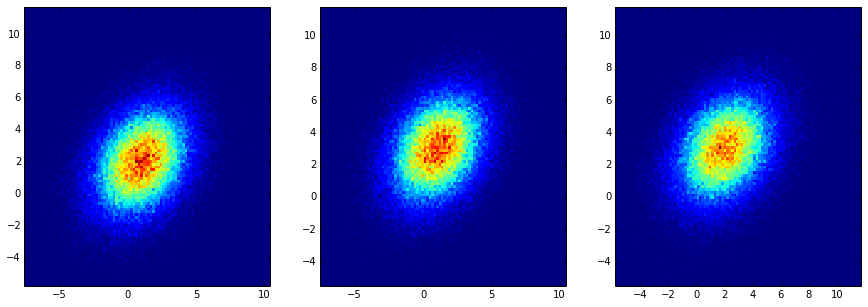

In [57]:
%matplotlib inline
from collections import defaultdict
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt

mu=[1,2,3] ## center
sig=[[4.,1.2,1.2],[1.2,4.,1.2],[1.2,1.2,4.]] ## covariance matrix
detsig=np.linalg.det(sig) ## compute the determinant
print detsig

x = np.random.multivariate_normal(mu,sig,100000)

plt.subplots(1,3,figsize=(15,5))

plt.subplot(1,3,1)
plt.hist2d(x[:,0],x[:,1], normed=True, bins=100)


plt.subplot(1,3,2)
plt.hist2d(x[:,0],x[:,2], normed=True, bins=100)


plt.subplot(1,3,3)
plt.hist2d(x[:,1],x[:,2], normed=True, bins=100)

plt.show()

We want to have a total of 10000 usable samples (below we actually use one oreder of magnitude more, to show the histrograms more clearly). As we have seen from our MH exercise before, a 20% burnin is a reasonable choice. As for the thinning, we want it to be large enough to break correlation between consecutive samples, but not so large that would make our code take too long to converge. For this exercise, a thinning of 5 seems reasonable, but feel free to experiment.

In [46]:
# Let us set things up

Ng=100000 # We want 1000 Gibbs Sample values
Ns=1 # We need 10 samples for part b
burnin=20000 # Burn−in samples
thin=5 # Thinning factor
Nmc= burnin + (Ng*thin) # Iterations within the loop  

mu = np.array([1,2,3])     # Mean vector of the multivariate normal distribution
sigma = np.array([[4,1.2, 1.2], [1.2, 4, 1.2],[1.2, 1.2, 4]])    # Covariance Matrix
sigma11 = 4.                                     # Submatrix
sigma12 = np.array([1.2, 1.2])                  # Submatrix
sigma22 = np.array([[4 ,1.2],[ 1.2, 4]])        # Submatrix
print sigma
print sigma22

[[ 4.   1.2  1.2]
 [ 1.2  4.   1.2]
 [ 1.2  1.2  4. ]]
[[ 4.   1.2]
 [ 1.2  4. ]]


In [47]:
inv = np.linalg.inv
def ddot(a,b,c):
    return np.dot(np.dot(a,b),c)
# Define sigma for conditional distributions
std_sigma = np.sqrt(sigma11 - ddot(sigma12, inv(sigma22), sigma12.T))
#std_sigma = sigma11 - ddot(sigma12, inv(sigma22), sigma12.T)
print std_sigma

1.85638192357


In [48]:
# Now let's calculate the conditional distributions on each of the parameters

mucondx = lambda y,z: mu[0] + ddot(sigma12, inv(sigma22), np.array([y-mu[1], z-mu[2]]).T)
mucondy = lambda x,z: mu[1] + ddot(sigma12, inv(sigma22), [x-mu[0], z-mu[2]]) 
mucondz = lambda x,y: mu[2] + ddot(sigma12, inv(sigma22), [x-mu[0], y-mu[1]])

We now run the Gibbs sampler:

In [49]:
# Allocate output memory
out_x = np.zeros((Ns,Ng)) 
out_y = np.zeros((Ns,Ng)) 
out_z = np.zeros((Ns,Ng))

In [50]:
for j in xrange(Ns): # Create Ns=10 samples
    # Initializing memory for intra−loop samples
    x = np.zeros(Nmc)
    y = np.zeros(Nmc)
    z = np.zeros(Nmc)
    # initial random values
    foo = std_sigma*np.random.randn(3, Nmc)
    x[0] = mu[0] + foo[0, 0]
    y[0] = mu[1] + foo[1, 0]
    z[0] = mu[2] + foo[2, 0]
    for i in np.arange(1,Nmc): # Gibbs Sampler
        #Calculate multivariate normals
        x[i]=mucondx(y[i-1],z[i-1]) + foo[0,i]
        y[i]=mucondy(x[i],z[i-1]) + foo[1,i]
        z[i]=mucondz(x[i],y[i]) + foo[2,i]
        
    # Populate the arrays , dump the burn−in and thin out x(j, :) = x(burnin+2:thin:end);
    out_x[j, :] = x[burnin+1::thin]
    out_y[j, :] = y[burnin+1::thin]
    out_z[j, :] = z[burnin+1::thin]

In [67]:
control_samples = np.random.multivariate_normal(mu,sig,Ng)

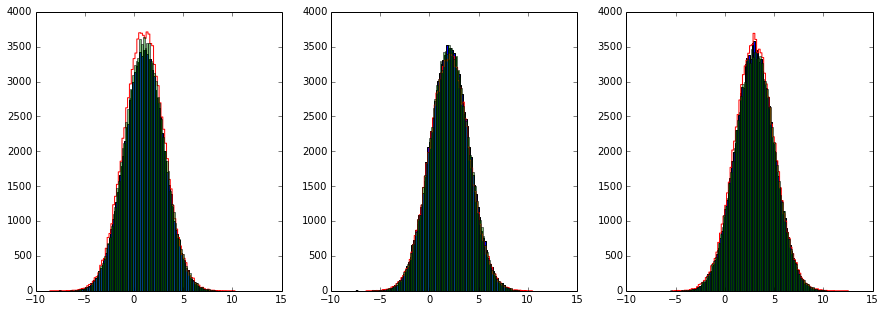

In [68]:
plt.subplots(1,3,figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(out_x[0,:], bins=100)
plt.hist(control_samples[:,0], bins=100, histtype="step", color='r')
plt.hist(x[:,0], bins=100,alpha=0.5)

plt.subplot(1,3,2)
plt.hist(out_y[0,:], bins=100)
plt.hist(control_samples[:,1], bins=100, histtype="step", color='r')
plt.hist(x[:,1], bins=100,alpha=0.5)

plt.subplot(1,3,3)
plt.hist(out_z[0,:], bins=100)
plt.hist(control_samples[:,2], bins=100, histtype="step", color='r')
plt.hist(x[:,2], bins=100,alpha=0.5)

plt.show()

Quick difference of mean test:

In [61]:
theta_a = np.mean(out_x[0,:])
theta_b = np.mean(control_samples[:,0])
var_a  = np.var(out_x[0,:])
var_b  = np.var(control_samples[:,0])
        
print (theta_a-theta_b)/np.sqrt( var_a + var_b)

-0.000745477718327


#### Solution to part (b).

In this part we do a similar excercise, but now we sample from the contitionals $Y(x,y|z)$ and $Y(z|x,y)$. This means that we will be doing blockwise updating in $(x,y)$. Thinks are pretty similar, but now we will be sampling from one univariate normal and a bivariate normal, rather than three univariate normals like in part (a). So we have to be careful with the definitions of our submatrices in each case.

In [62]:
# Let us set things up

Ng=100000 # We want 1000 Gibbs Sample values
Ns=1 # We need 10 samples for part b
burnin=20000 # Burn−in samples
thin=5 # Thinning factor
Nmc= burnin + (Ng*thin) # Iterations within the loop  

mu = np.array([1.,2.,3.])     # Mean vector of the multivariate normal distribution
sigma = np.array([[4.,1.2, 1.2], [1.2, 4., 1.2],[1.2, 1.2, 4.]])    # Covariance Matrix
sigma11_xy = np.array([[4. ,1.2],[ 1.2, 4.]])                                     # Submatrix
sigma12_xy = np.array([1.2, 1.2]).T                  # Submatrix
sigma22_xy = 4.        # Submatrix

sigma11_z = 4.                                     # Submatrix
sigma12_z = np.array([1.2, 1.2])                  # Submatrix
sigma22_z = np.array([[4. ,1.2],[ 1.2, 4.]])        # Submatrix


In [63]:
std_sigma_xy = sigma11_xy - ddot(sigma12_xy, 1/sigma22_xy, sigma12_xy.T)
std_sigma_z = np.sqrt(sigma11_z - ddot(sigma12_z, inv(sigma22_z), sigma12_z.T))
print std_sigma_xy
print std_sigma_z

[[ 3.28  0.48]
 [ 0.48  3.28]]
1.85638192357


In [64]:
# Now let's calculate the conditional distributions on each of the parameters

mucond_x_y = lambda z: [mu[0], mu[1]] + ddot(sigma12_xy, 1/sigma22_xy, z-mu[2])
mucondz = lambda x_y: mu[2] + ddot(sigma12_z, inv(sigma22_z), x_y-[mu[0],mu[1]])

In [65]:
# Allocate output memory
out_x_y = np.zeros((Ns,2,Ng)) 
out_z = np.zeros((Ns,Ng))


In [66]:
for j in xrange(Ns): # Create Ns=10 samples
    # Initializing memory for intra−loop samples
    x_y = np.zeros((2, Nmc)).T
    z = np.zeros(Nmc)
    # initial random values
    foo_xy = np.random.multivariate_normal([0,0], std_sigma_xy, Nmc)
    foo_z = std_sigma_z*np.random.randn(1, Nmc)
    x_y[0] = [mu[0], mu[1]] + foo_xy[0]
    z[0] = mu[2] + foo_z[0, 0]
    for i in np.arange(1,Nmc): # Gibbs Sampler
        #Calculate multivariate normals
        x_y[i]=mucond_x_y(z[i-1]) + foo_xy[i]
        z[i]=mucondz(x_y[i]) + foo_z[0,i]
        
    # Populate the arrays , dump the burn−in and thin out x(j, :) = x(burnin+2:thin:end);
    print shape(out_x_y[j, :]),shape(x_y[burnin+1::thin].T)
    out_x_y[j, :] = x_y[burnin+1::thin].T
    out_z[j, :] = z[burnin+1::thin]

(2, 100000) (2, 100000)


In [69]:
control_samples = np.random.multivariate_normal(mu,sig,Ng)

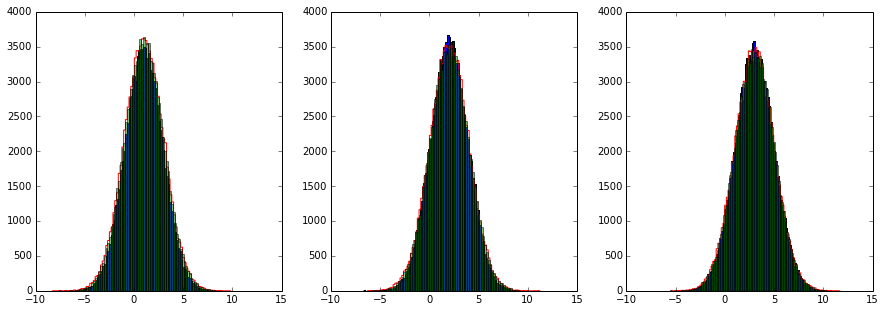

In [70]:
plt.subplots(1,3,figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(out_x_y[0,0,:], bins=100)
plt.hist(control_samples[:,0], bins=100, histtype="step", color='r')
plt.hist(x[:,0], bins=100,alpha=0.5)

plt.subplot(1,3,2)
plt.hist(out_x_y[0,1,:], bins=100)
plt.hist(control_samples[:,1], bins=100, histtype="step", color='r')
plt.hist(x[:,1], bins=100,alpha=0.5)

plt.subplot(1,3,3)
plt.hist(out_z[0,:], bins=100)
plt.hist(control_samples[:,2], bins=100, histtype="step", color='r')
plt.hist(x[:,2], bins=100,alpha=0.5)

plt.show()

The distributions look pretty similar to part (a), which shows that regardles of the use of componentwise or blockwise updating, we arrive at the same answer, but blockwise updating is faster.

### Question 2: Motif finding for extraterrestrial biology.

You are a biologist who is analyzing some genetic material that astronauts collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases (unlike your DNA, that is made by combining only 4 nucleotides). You have named these extraterrestrial nucleotides 'F', 'R', 'L', 'A', and 'E'. NASA has given you a DNA sample consisting of $p=20$ sequences of DNA, each of them with a lenght $l=100$ nucleotide bases that you can find in <a href="Sequences.dat">this file</a>. Each row of the table is a DNA string. You are asked to find a particular substring (we call it a motif) of $k = 6$ consecutive nucleotides that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences. You quickly realize that the problem is equivalent to maximizing the joint probability distribution $p(x_1,x_2,...,x_p)$ in a p-dimensional space that the most "mutually similar" motif (in this case an identical sequence of $k$ elements) starts at positions $\left\{x_1,x_2,...,x_p\right\}$ of your set of $p$ sequences. 

Think about this in terms of Gibbs sampling. Maybe you can find the conditional probability of the hidden motif starting at position $j$ of your *i-th* string, given the current starting positions of the $k$-subsequence in all other strings. Let us help you out:

(a) Start by assigning random starting positions for the $k$-long motif in all sequences. Now exclude the first string and construct a matrix with dimension $(k+1)\times n_B$ where, for $j$ in $[1,k+1]$, element in column $j$ and row $i$ is the number of times that the *i-th* base is in position $j$, given the current starting points of the $p-1$ remaining sequences. Add an extra column (column 0) to account for the number of times that base the *i-th* appears in the background (not inside a motif). Now calculate a probability matrix:

$$
    P[i,j]= 
\begin{cases}
    \frac{C[i,j]+0.5}{p-1+0.5*n_B},& \text{           for } j \text{ in } [1,k+1]\\
    \frac{C[i,0]+0.5}{(l-k)*(p-1)+0.5*n_B},& \text{           for } j = 0
\end{cases}
$$

where the $C[i,j]$ are the number of counts in each case. The additional term of $0.5$ is a pseudocunt added to avoid infinities. 

(b) Think about how you can use this probability matrix to calculate the conditional probability $p(x_j|x_1,x_2,...,x_{j-1},x_{j+1},...,x_p)$) that the hidden motif starts in position $x_j$ of the first sequence. HINT: Given the probability of bases in different positions for all other sequences, what is the probability of having the observed nucleotide bases in the current sequence and current position?
 
(b) Construct a Gibbs sampling algorithm that, starting at random positions for all sequences, iterates this process over the $p=20$ different DNA sequences and generates an updated set of starting positions $\left\{x_1^{i+1},x_2^{i+1},...,x_p^{i+1}\right\}$, sampling from the conditional probabilities, until the updated positions converge. Provide the hidden motif and the starting positions of it in each of the sequences.

#### Solution to part (a).

This problem is common in DNA sequencing and it is known as motif finding. A good way to solve it is as follows: the idea is that at each step, we update the starting position for the motif in a given sequence using the information contained in all the other sequences and their current starting positions of the motif. In other words, with all fixed positions of the motif in the remaining sequences, at each step we are finding the probability distribution of my motif starting at different positions of my current sequence, conditioned on all other sequences being known. And then we sample the next position within my current sequence from that conditional probability (this is Gibbs), and continue with the next sequence. After enough iterations over all sequences, you will converge towards the starting positions that give very similar motifs.

(1) Initialization

So, the first step is to start at random positions for all the $p$ sequences. You exclude one of the sequences (let's say the first one, which we will now call our current sequence), and construct a matrix with dimension $k\times n_B$ where element in column $j$ and row $i$ is the number of times that the $\textit{i-th}$ base is in position $j$ given the current starting points of the remaining sequences. So, if your sequences look like:

                         L    E    L  | L    R    E    A    A    F  | A   ====> EXCLUDE!
                         E  | L    E    E    R    R    E  | F    R    L
                         A    L    F    L  | R    A    R    L    R    E |
                         A    F  | F    A    R    E    R    E  | E    A
                         
Then your matrix looks like:

                              0    1    2    3    4    5    6      
                         F    3    1    0    0    0    0    0
                 C   =   R    1    1    0    2    1    3    0  
                         L    3    1    0    0    1    0    0 
                         A    3    0    2    0    0    0    0 
                         E    2    0    1    1    1    0    3
                         
 Where we have added a '0' column to account for the number of times that the bases fall in the background.

(2) Predictive update

Starting with our count matrix, we can now calculate our probability matrix as:

$$P[i,j] = \frac{C[i,j]+0.5}{p-1+0.5*n_B}$$

where we have added the pseudocounts. So for each base in each position, this likelihood probbaility is equal to the number of times base $i$ appears in position $j$, divided by the number of times it appears in the background. For the background column:

$$P[i,0] = \frac{C[i,0]+0.5}{\sum_{i\neq 1}(l-k)+0.5*n_B}$$

which means that the probability of base $i$ being in the background equals the number of times it appears in the background divided by the spots available in the background.

(3) Sampling

Now we build the conditional probability for our current sequence and its current motif starting position as the product of the probabilities that we would observe the given letters in the given order: L R E A A F. That is: the product of the probability of L being in the first position, times the probability of R being in the second position, etc. And then we still have to divide by the probability of each base being in a random string, from the background probabilities:

$$p(x_j|x_1,x_2,...,x_{j-1},x_{j+1},...,x_p) = \prod_{i=1}^k \frac{P_i(b_i)}{Bg(b_i)}$$

where $P_i(b_i) = P[i,j]$ is the probability that the *i-th* position has the given base $b_i$, and $Bg(b_i)=P[i,0]$ is the probability of observing the base $b_i$ at random.

We can normalize this conditional probability and then sample our next starting position for the motif from the resulting distribution.


(4) Iteration

Now that we have sampled the new position for the first sequence, we move to the next sequence and repeat the process. After we have done it for all $p$ sequences, we iterate until the proposed starting positions do not change. Let us implement it:

#### Solution to part (b)

In [1]:
# We start by loading the data and defining the parameters.

import random
import numpy as np
from numpy.random import random_sample


#lines = [line.rstrip('\n') for line in file]
with open('Sequences.dat') as f:
    Seqs = [line.rstrip('\n') for line in f]
    #Seqs = [line.rstrip('\n') for line in file]
#for x in Seqs: print len(x) - k

#random.randint(0, 200)
    
bases = ['F', 'R', 'L', 'A','E']
n_b = 5  # Numer of bases
l = len(Seqs[0])  # Length of strings
k = 6   # Length of motif
p = len(Seqs)  # Number of strings


In [2]:
# NOW WE DEFINE ALL USEFUL FUNCTIONS

# We first define a function that calculates the position frequency matrix (C)
def calc_PFM(Sequence,seq_excluded,I):    
    PFM = np.zeros(shape=(n_b,k+1))   # Initialize matrix
    
    for i in np.arange(p):               # Loop over strings
        if i != seq_excluded:         # Exclude a particular string
            subseq = Sequence[i][I[i]:I[i]+k]      # define substring of size k
            compl = Sequence[i][0:I[i]]+Sequence[i][I[i]+k:]    # complement of the substring
            
            for j in np.arange(n_b):     # Loop over bases
                if (compl.count(bases[j]) > 0): 
                    PFM[j,0] += compl.count(bases[j])    # Add a count if current base in background
                for h in np.arange(k): 
                    if (subseq[h] == bases[j]): PFM[j,h+1] += 1  # Add a count if baje j is in position h of the string
                               
    return PFM
 
    
# Now we define a function to calculate the probability matrix (P)
def calc_PWM(PFM_0):
    pseudocnt = 0.5  # Pseudocounts added to avoid probabilities of zero.
    PWM = np.zeros(shape=(n_b,k+1))   # Initialize matrix
    for i in np.arange(n_b):
        PWM[i,0] = (PFM_0[i,0] + pseudocnt)/((l-k)*(p-1)+pseudocnt*n_b)   # Probability of finding ith base in background
        for j in np.arange(1,k+1):
            PWM[i,j] = (PFM_0[i,j] + pseudocnt)/(p-1+pseudocnt*n_b)       # Probability of finding ith base in position j
    return PWM


# Now we define a function to calculate the probability of next position of motif in sequence, from the likelikood ratios (The conditional probability)
def calc_likelihood(PWM_0,seq_excluded):
    Likelihood_seq = np.zeros(l-k+1)  # Array for likelihoods of given motif starting at each of the possible positions of string
    Likelihood_bkgnd = np.zeros(l-k+1)  # Array for likelihoods of given starting at the background
    #A = 1
    #print A
    current_string = Seqs[seq_excluded]  # This is my current string
    #print current_string
    for i in np.arange(l-k+1):              # Loop over the possible starting positions
        current_subseq = current_string[i:i+k]     # Proposed motif position
        
        Likelihood_seq_0 = 0   # Initialize Likelihood_seq
        Likelihood_bkgnd_0 = 0  # Initialize Likelihood_bckgnd
        for j in np.arange(k):             # Loop over the length of the motif
            for h in np.arange(n_b):       # Loop over bases
                if (current_subseq[j] == bases[h]):
                    #print PWM_0[h,j+1]
                    Likelihood_seq_0 += PWM_0[h,j+1]  # Fill in Likelihood_seq. If PWM is logarithmic this can be done a a sum
                    Likelihood_bkgnd_0 += PWM_0[h,0]  # Fill in Likelihood_bckgnd
                    
            Likelihood_seq[i] = 10.0**Likelihood_seq_0
            Likelihood_bkgnd[i] = 10.0**Likelihood_bkgnd_0
    norm_fact = np.sum(Likelihood_seq/Likelihood_bkgnd)   # Normalize probability 
    return (Likelihood_seq/Likelihood_bkgnd)/norm_fact    # Probaility of new position i in chosen sequence

# Finally we create a function to sample from the conditional probability.
def weighted_values(values, probabilities, size):
    bins = np.add.accumulate(probabilities)
    return values[np.digitize(random_sample(size), bins)]

After we have defined our functions to calculate the conditional probability, we iterate many times over the $p$ sequences, until we converge to a final set of starting positions:

In [3]:
def gibbs(Seqs, k):
    """Seqs is a list of strings. Find the best motif."""
    
    # start with random indices
    I = [random.randint(0, l - k) for x in Seqs]
    
    LastI = None
    #for repeats in arange(2000):
    #while I != LastI: # repeat until nothing changes
    for i in np.arange(100):
        LastI = list(I)
        #print I   
        # iterate through every string
        for i in xrange(len(Seqs)):
            
        # compute the profile for the sequences except i

            P = np.log10(calc_PWM(calc_PFM(Seqs,i,I)))  # I take the logarithm so that I can calculate the likelihood as a sum
        
                
            # find the place the profile matches best
            
            for j in xrange(len(Seqs[i]) - k + 1):
                
                score_arr = calc_likelihood(P,i)
                
            I[i] = int(np.mean(weighted_values(np.arange(len(Seqs[i]) - k + 1),score_arr,1)))
        print LastI
            
    return I, [x[j : j + k] for x, j in zip(Seqs, I)]

In [4]:
#for i in arange(100):
result = gibbs(Seqs, k)
#print result

[89, 87, 0, 71, 29, 50, 82, 41, 88, 10, 67, 89, 24, 71, 49, 64, 90, 26, 52, 0]
[23, 48, 9, 71, 47, 67, 12, 66, 20, 57, 25, 55, 28, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66]
[23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 

Wow! We have discovered that the hidden motif is the name of one of our TFs!! Weird stuff!

In [5]:
print result

([23, 46, 7, 69, 6, 67, 10, 66, 20, 57, 25, 55, 26, 62, 53, 28, 52, 16, 52, 66], ['RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL', 'RAFAEL'])


Please note that this will not always converge to the hidden motif, partly because of the low frequency of base 'E', as some of you pointed out. However, it does often converge to the right answer, and by running your code a few times you should arrive to the right answer.